In [1]:
# import independencies
import numpy as np
import pandas as pd
import datetime
from pathlib import Path
from collections import Counter

In [2]:
#import ML independencies
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#import tensorflow as tf


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
#Reading sample file into a dataframe
#file_path = Path('Datasource/sample_covid_dataset.csv')
file_path = Path('../Datasource/sample_covid_dataset.csv')
cases_df = pd.read_csv(file_path)
cases_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,_id,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,...,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,0,9,9,353345,353346,353346,2020-12-14T00:00:00,2020-12-20T00:00:00,2020-12-20T00:00:00,2020-12-16T00:00:00,...,Resolved,Yes,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
1,1,15,15,35074,35075,35075,2020-11-08T00:00:00,2020-11-09T00:00:00,2020-11-09T00:00:00,2020-11-08T00:00:00,...,Resolved,Yes,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
2,2,16,16,131940,131941,131941,2021-02-03T00:00:00,2021-02-05T00:00:00,2021-02-05T00:00:00,2021-02-03T00:00:00,...,Resolved,Yes,2246,Niagara Region Public Health Department,1815 Sir Isaac Brock Way,Thorold,L2V 4T7,www.niagararegion.ca/health,43.116537,-79.241220
3,3,24,24,205768,205769,205769,2020-12-24T00:00:00,2020-12-29T00:00:00,2020-12-29T00:00:00,2020-11-26T00:00:00,...,Resolved,Yes,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
4,4,26,26,387017,387018,387018,2021-01-21T00:00:00,2021-01-23T00:00:00,2021-01-23T00:00:00,2021-01-21T00:00:00,...,Resolved,Yes,2246,Niagara Region Public Health Department,1815 Sir Isaac Brock Way,Thorold,L2V 4T7,www.niagararegion.ca/health,43.116537,-79.241220


# Cleaning Data 

In [4]:
# Check the columns
cases_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       '_id', 'Row_ID', 'Accurate_Episode_Date', 'Case_Reported_Date',
       'Test_Reported_Date', 'Specimen_Date', 'Age_Group', 'Client_Gender',
       'Case_AcquisitionInfo', 'Outcome1', 'Outbreak_Related',
       'Reporting_PHU_ID', 'Reporting_PHU', 'Reporting_PHU_Address',
       'Reporting_PHU_City', 'Reporting_PHU_Postal_Code',
       'Reporting_PHU_Website', 'Reporting_PHU_Latitude',
       'Reporting_PHU_Longitude'],
      dtype='object')

In [5]:
# Drop unrelated columns from dataframe

columns_to_drop=['Unnamed: 0','Unnamed: 0.1', 'Unnamed: 0.1.1','Unnamed: 0.1.1.1', '_id', 'Row_ID', 'Outbreak_Related',
                'Accurate_Episode_Date','Test_Reported_Date','Specimen_Date','Case_AcquisitionInfo','Reporting_PHU','Reporting_PHU_Address', 
                'Reporting_PHU_City' , 'Reporting_PHU_Website',
                'Reporting_PHU_Latitude', 'Reporting_PHU_Longitude'
               ]
cleaned_cases_df = cases_df.drop(columns= columns_to_drop)


In [6]:
cleaned_cases_df.columns

Index(['Case_Reported_Date', 'Age_Group', 'Client_Gender', 'Outcome1',
       'Reporting_PHU_ID', 'Reporting_PHU_Postal_Code'],
      dtype='object')

In [7]:
# Rename columns to short version

cleaned_cases_df = cleaned_cases_df.rename(columns={"Case_Reported_Date": "Date",'Client_Gender':"Gender",
                                                    'Outcome1':'Outcome','Reporting_PHU_ID':'PHU_id'})
cleaned_cases_df.columns

Index(['Date', 'Age_Group', 'Gender', 'Outcome', 'PHU_id',
       'Reporting_PHU_Postal_Code'],
      dtype='object')

In [8]:
cleaned_cases_df

,Date,Age_Group,Gender,Outcome,PHU_id,Reporting_PHU_Postal_Code
0,2020-12-20T00:00:00,70s,FEMALE,Resolved,3895,M5B 1W2
1,2020-11-09T00:00:00,<20,FEMALE,Resolved,3895,M5B 1W2
2,2021-02-05T00:00:00,20s,MALE,Resolved,2246,L2V 4T7
3,2020-12-29T00:00:00,20s,MALE,Resolved,3895,M5B 1W2
4,2021-01-23T00:00:00,90+,FEMALE,Resolved,2246,L2V 4T7
...,...,...,...,...,...,...
13519,2021-03-16T00:00:00,20s,FEMALE,Resolved,2253,L5W 1N4
13520,2021-01-07T00:00:00,80s,FEMALE,Resolved,2261,P3E 3A3
13521,2021-02-08T00:00:00,80s,FEMALE,Resolved,3895,M5B 1W2
13522,2021-01-20T00:00:00,40s,FEMALE,Resolved,2253,L5W 1N4


In [9]:
# Convert the target column values to Resolved and Not_Resolved 

cleaned_cases_df = cleaned_cases_df.drop(cleaned_cases_df[cleaned_cases_df['Outcome'] == "Not Resolved"].index)
cleaned_cases_df.Outcome.value_counts()

Resolved    12398
Fatal         811
Name: Outcome, dtype: int64

In [10]:
#Converting date column

cleaned_cases_df['Date'] = pd.to_datetime(cleaned_cases_df['Date'], errors='coerce')

In [11]:
#Converting Date to ordinal day
cleaned_cases_df['Day'] = cleaned_cases_df['Date'].apply(lambda x: datetime.date.toordinal(x))-datetime.date.toordinal(datetime.date(2020,3,7))


In [12]:
#extracting 3 digits of postal code 
cleaned_cases_df['Postal_code']=cleaned_cases_df['Reporting_PHU_Postal_Code'].str[0:1]
cleaned_cases_df = cleaned_cases_df.drop(columns=['Reporting_PHU_Postal_Code'])
cleaned_cases_df

,Date,Age_Group,Gender,Outcome,PHU_id,Day,Postal_code
0,2020-12-20,70s,FEMALE,Resolved,3895,288,M
1,2020-11-09,<20,FEMALE,Resolved,3895,247,M
2,2021-02-05,20s,MALE,Resolved,2246,335,L
3,2020-12-29,20s,MALE,Resolved,3895,297,M
4,2021-01-23,90+,FEMALE,Resolved,2246,322,L
...,...,...,...,...,...,...,...
13519,2021-03-16,20s,FEMALE,Resolved,2253,374,L
13520,2021-01-07,80s,FEMALE,Resolved,2261,306,P
13521,2021-02-08,80s,FEMALE,Resolved,3895,338,M
13522,2021-01-20,40s,FEMALE,Resolved,2253,319,L


In [13]:
# Drop Date column

cleaned_cases_df = cleaned_cases_df.drop(columns=['Date'])

In [14]:
cleaned_cases_df 

,Age_Group,Gender,Outcome,PHU_id,Day,Postal_code
0,70s,FEMALE,Resolved,3895,288,M
1,<20,FEMALE,Resolved,3895,247,M
2,20s,MALE,Resolved,2246,335,L
3,20s,MALE,Resolved,3895,297,M
4,90+,FEMALE,Resolved,2246,322,L
...,...,...,...,...,...,...
13519,20s,FEMALE,Resolved,2253,374,L
13520,80s,FEMALE,Resolved,2261,306,P
13521,80s,FEMALE,Resolved,3895,338,M
13522,40s,FEMALE,Resolved,2253,319,L


In [15]:
# Saving the dataframe into csv file
cleaned_cases_df.to_csv('../Datasource/cleaned_covid_data.csv')

In [16]:
pc_count =cleaned_cases_df.Postal_code.value_counts()
pc_count

L    5734
M    3511
N    2418
K    1146
P     400
Name: Postal_code, dtype: int64

# Processing Data for ML 

In [17]:
cleaned_cases_df

,Age_Group,Gender,Outcome,PHU_id,Day,Postal_code
0,70s,FEMALE,Resolved,3895,288,M
1,<20,FEMALE,Resolved,3895,247,M
2,20s,MALE,Resolved,2246,335,L
3,20s,MALE,Resolved,3895,297,M
4,90+,FEMALE,Resolved,2246,322,L
...,...,...,...,...,...,...
13519,20s,FEMALE,Resolved,2253,374,L
13520,80s,FEMALE,Resolved,2261,306,P
13521,80s,FEMALE,Resolved,3895,338,M
13522,40s,FEMALE,Resolved,2253,319,L


In [18]:
#cleaned_cases_df.dtypes

In [19]:
# Generate our categorical variable list except PHU
covid_cat = cleaned_cases_df.dtypes[cleaned_cases_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
cleaned_cases_df[covid_cat].nunique()

Age_Group      9
Gender         4
Outcome        2
Postal_code    5
dtype: int64

In [20]:
# Create a OneHotEncoder instance, Sparse = false returns an array otherwise it returns a matrix
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(cleaned_cases_df[covid_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(covid_cat)

#change the column names to remove the space
encode_df = encode_df.rename(columns={'Gender_GENDER DIVERSE':'Gender_GENDER_DIVERSE'})

encode_df.head()

,Age_Group_20s,Age_Group_30s,Age_Group_40s,Age_Group_50s,Age_Group_60s,Age_Group_70s,Age_Group_80s,Age_Group_90+,Age_Group_<20,Gender_FEMALE,Gender_GENDER_DIVERSE,Gender_MALE,Gender_UNSPECIFIED,Outcome_Fatal,Outcome_Resolved,Postal_code_K,Postal_code_L,Postal_code_M,Postal_code_N,Postal_code_P
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [21]:
# Merge the two DataFrames together and drop the PHU_id column
cat_df = cleaned_cases_df.merge(encode_df,left_index=True,right_index=True)


In [22]:
# drop categorial columns
cat_df = cat_df.drop(columns=['Age_Group','Gender','Outcome','Postal_code'])


In [23]:
#cat_df.dtypes

In [24]:
# Check the unique value counts to see if binning is required
# PHU ID
PHU_count =cat_df.PHU_id.value_counts()


<AxesSubplot:ylabel='Density'>

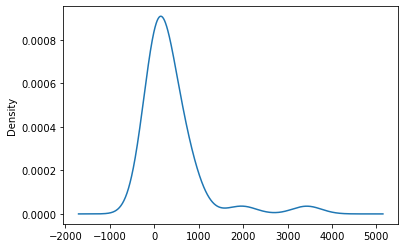

In [25]:
# Visualize the value counts
PHU_count.plot.density()

In [26]:
# Determine which values to replace
replace_PHU = list(PHU_count[PHU_count < 400].index)


In [27]:
# Replace in DataFrame
for phu in replace_PHU:
    cat_df.PHU_id = cat_df.PHU_id.replace(phu,"Other")

In [28]:
# Check to make sure binning was successful
cat_df.PHU_id.value_counts()

3895     3434
Other    2338
2253     1971
2270      912
2251      773
2268      686
2246      685
2237      586
2230      568
2265      502
2236      449
Name: PHU_id, dtype: int64

In [29]:
#Converting PHU_id to categorial feature
cat_df['PHU_id'] = cleaned_cases_df.PHU_id.astype(str) 

In [30]:
# Create the OneHotEncoder instance 

enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame for PHU_ids
encode_df = pd.DataFrame(enc.fit_transform(cat_df.PHU_id.values.reshape(-1,1)))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(['PHU'])
encode_df.head()

,PHU_2226,PHU_2227,PHU_2230,PHU_2233,PHU_2234,PHU_2235,PHU_2236,PHU_2237,PHU_2238,PHU_2240,...,PHU_2261,PHU_2262,PHU_2263,PHU_2265,PHU_2266,PHU_2268,PHU_2270,PHU_3895,PHU_4913,PHU_5183
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Merge the two DataFrames together and drop the PHU_id column
covid_df = cat_df.merge(encode_df,left_index=True,right_index=True).drop('PHU_id',1)
covid_df

,Day,Age_Group_20s,Age_Group_30s,Age_Group_40s,Age_Group_50s,Age_Group_60s,Age_Group_70s,Age_Group_80s,Age_Group_90+,Age_Group_<20,...,PHU_2261,PHU_2262,PHU_2263,PHU_2265,PHU_2266,PHU_2268,PHU_2270,PHU_3895,PHU_4913,PHU_5183
0,288,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,335,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,297,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12899,391,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12900,231,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12901,372,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12902,244,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
covid_df.columns

Index(['Day', 'Age_Group_20s', 'Age_Group_30s', 'Age_Group_40s',
       'Age_Group_50s', 'Age_Group_60s', 'Age_Group_70s', 'Age_Group_80s',
       'Age_Group_90+', 'Age_Group_<20', 'Gender_FEMALE',
       'Gender_GENDER_DIVERSE', 'Gender_MALE', 'Gender_UNSPECIFIED',
       'Outcome_Fatal', 'Outcome_Resolved', 'Postal_code_K', 'Postal_code_L',
       'Postal_code_M', 'Postal_code_N', 'Postal_code_P', 'PHU_2226',
       'PHU_2227', 'PHU_2230', 'PHU_2233', 'PHU_2234', 'PHU_2235', 'PHU_2236',
       'PHU_2237', 'PHU_2238', 'PHU_2240', 'PHU_2241', 'PHU_2242', 'PHU_2243',
       'PHU_2244', 'PHU_2246', 'PHU_2247', 'PHU_2249', 'PHU_2251', 'PHU_2253',
       'PHU_2255', 'PHU_2256', 'PHU_2257', 'PHU_2258', 'PHU_2260', 'PHU_2261',
       'PHU_2262', 'PHU_2263', 'PHU_2265', 'PHU_2266', 'PHU_2268', 'PHU_2270',
       'PHU_3895', 'PHU_4913', 'PHU_5183'],
      dtype='object')

In [33]:
# Remove 'Active_cases' target from features data
y = covid_df.Outcome_Resolved
X = covid_df.drop(columns = ['Outcome_Resolved', 'Outcome_Fatal'])

In [34]:
# Split our preprocessed data into our features and target arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# RandomForest Classifier

In [35]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.908


In [36]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
cm, index=["Fatal", "Resolved"], columns=["Predicted Fatal", "Predicted Resolved"])

cm_df

,Predicted Fatal,Predicted Resolved
Fatal,57,137
Resolved,152,2806


In [37]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)

In [38]:
# Displaying results
print("\033[1m\nConfusion Matrix\n")
display(cm_df)
print ('\n')
print(f"\033[1mAccuracy Score :\033[94m {acc_score:.3f}\n")
print ('\033[0m\n')
print("\033[1mClassification Report\n")
print(classification_report(y_test, y_pred))


Confusion Matrix



,Predicted Fatal,Predicted Resolved
Fatal,57,137
Resolved,152,2806




Accuracy Score : 0.908



Classification Report

              precision    recall  f1-score   support

         0.0       0.27      0.29      0.28       194
         1.0       0.95      0.95      0.95      2958

    accuracy                           0.91      3152
   macro avg       0.61      0.62      0.62      3152
weighted avg       0.91      0.91      0.91      3152

